# Инструменты для работы с языком 

## Задача: классификация твитов по тональности

У нас есть датасет из твитов, про каждый указано, как он эмоционально окрашен: положительно или отрицательно. Задача: предсказывать эмоциональную окраску.

Скачиваем куски датасета ([источник](http://study.mokoron.com/)): [положительные](https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0), [отрицательные](https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv).

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [2]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
df = positive.append(negative)

In [3]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.label)

## Baseline: классификация необработанных n-грамм

### Векторизаторы

In [4]:
from sklearn.linear_model import LogisticRegression # можно заменить на любимый классификатор
from sklearn.feature_extraction.text import CountVectorizer

Что такое n-граммы:

In [7]:
from nltk import ngrams

## Стоп-слова и пунктуация

*Стоп-слова* -- это слова, которые часто встречаются практически в любом тексте и ничего интересного не говорят о конретном документе, то есть играют роль шума. Поэтому их принято убирать. По той же причине убирают и пунктуацию.

In [47]:
# у вас здесь, вероятно, выскочит ошибка и надо будет загрузить стоп слова (в тексте ошибки написано, как)
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/vlad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [7]:
noise = stopwords.words('russian') + list(punctuation)

В векторизаторах за стоп-слова, логичным образом, отвечает аргумент `stop_words`.

In [8]:
from nltk import word_tokenize

## Словарь, закон Ципфа и закон Хипса

Закон Ципфа -- эмпирическая закономерность: если все слова корпуса текста упорядочить по убыванию частоты их использования, то частота n-го слова в таком списке окажется приблизительно обратно пропорциональной его порядковому номеру n. Иными словами, частотность слов убывает очень быстро.

In [24]:
from collections import Counter

In [25]:
corpus = [token for tweet in df.text for token in word_tokenize(tweet) if token not in punctuation]
print(len(corpus))
corpus[:10]

2870536


['first_timee', 'хоть', 'я', 'и', 'школота', 'но', 'поверь', 'у', 'нас', 'то']

In [26]:
freq_dict = Counter(corpus)
freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:10]

[('не', 69472),
 ('и', 55166),
 ('в', 52902),
 ('я', 52818),
 ('RT', 38070),
 ('на', 35759),
 ('http', 32998),
 ('что', 31541),
 ('с', 27217),
 ('а', 26860)]

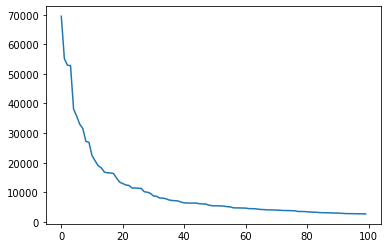

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
first_100_freqs = [freq for word, freq in freq_dict_sorted[:100]]
plt.plot(first_100_freqs)
plt.show()

Закон Хипса -- обратная сторона закона Ципфа. Он описывает, что чем больше корпус, тем меньше новых слов добавляется с добавлением новых текстов. В какой-то момент корпус насыщается.

## Задание 1.

**Задание**: обучите три классификатора: 

1) на токенах с высокой частотой 

2) на токенах со средней частотой 

3) на токенах с низкой частотой

Сравните полученные результаты, оцените какие токены наиболее важные для классификации.

In [28]:
freq_dict_sorted[:10]

[('не', 69472),
 ('и', 55166),
 ('в', 52902),
 ('я', 52818),
 ('RT', 38070),
 ('на', 35759),
 ('http', 32998),
 ('что', 31541),
 ('с', 27217),
 ('а', 26860)]

In [60]:
high = set([i[0].lower() for i in freq_dict_sorted if i[1] > 5000 and i[0].lower() not in noise])
medium = set([i[0].lower() for i in freq_dict_sorted if 300 <= i[1] < 5000 and i[0].lower() not in noise])
low = set([i[0].lower() for i in freq_dict_sorted if i[1] < 300 and i[0].lower() not in noise])

In [63]:
len(high), len(medium), len(low)

(15, 600, 315191)

In [36]:
def my_preproc_custom(text, frequency):
    text = re.sub('[{}]'.format(punctuation), '', text)
    text = mystem_analyzer.lemmatize(text)
    return [word for word in text if word in frequency]

# def my_preproc_medium(text):
#     text = re.sub('[{}]'.format(punctuation), '', text)
#     text = mystem_analyzer.lemmatize(text)
#     return [word for word in text if word in high]

In [40]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=lambda x: my_preproc_custom(x, high))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)

In [41]:
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.80      0.53      0.64     41938
    positive       0.32      0.62      0.42     14771

    accuracy                           0.55     56709
   macro avg       0.56      0.57      0.53     56709
weighted avg       0.67      0.55      0.58     56709



In [130]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=lambda x: my_preproc_custom(x, medium))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.47      0.65      0.55     20256
    positive       0.75      0.59      0.66     36453

    accuracy                           0.61     56709
   macro avg       0.61      0.62      0.60     56709
weighted avg       0.65      0.61      0.62     56709



In [62]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=lambda x: my_preproc_custom(x, low))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.76      0.72      0.74     29278
    positive       0.72      0.75      0.73     27431

    accuracy                           0.74     56709
   macro avg       0.74      0.74      0.74     56709
weighted avg       0.74      0.74      0.74     56709



###  Логично, что для обобщающей способности классификатора наиболее важны редкие токены






































## О важности эксплоративного анализа

Но иногда пунктуация бывает и не шумом -- главное отталкиваться от задачи. Что будет если вообще не убирать пунктуацию?

In [45]:
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00     27876
    positive       1.00      1.00      1.00     28833

    accuracy                           1.00     56709
   macro avg       1.00      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709



Шок! Стоило оставить пунктуацию -- и все метрики равны 1. Как это получилось? Среди неё были очень значимые токены (как вы думаете, какие?). Найдите фичи с самыми большими коэффициэнтами:

## Задание 2.

найти фичи с наибольшей значимостью, и вывести их

In [57]:
sorted([(i, j) for i, j in zip(vec.get_feature_names(), clf.coef_[0])], key=lambda x: -x[1])[:20]

[(')', 58.28809624959113),
 ('d', 26.901393960038757),
 ('dd', 10.622200359635846),
 ('^_^', 9.176231553227357),
 ('ddd', 8.134235722014749),
 ('-d', 7.273158195647029),
 ('*', 7.238638002729514),
 (':', 5.976265660415659),
 ('dddd', 4.802664458674663),
 ('ddddd', 2.9528262983503946),
 ('dddddd', 1.819570767682661),
 ('=^_^=', 1.7299306783359976),
 ('люблю', 1.6699543603888973),
 ('спасибо', 1.602575559114406),
 ('х', 1.5205892917957158),
 ('%', 1.3675840094458107),
 ('рождения', 1.2564531990855863),
 ('ахахах', 1.2177909883208682),
 ('ахах', 1.1850680145402248),
 ('dddddddd', 1.1774892492611042)]

Посмотрим, как один из супер-значительных токенов справится с классификацией безо всякого машинного обучения:

In [58]:
cool_token = ')'
pred = ['positive' if cool_token in tweet else 'negative' for tweet in x_test]
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       1.00      0.85      0.92     32756
    positive       0.83      1.00      0.91     23953

    accuracy                           0.91     56709
   macro avg       0.92      0.93      0.91     56709
weighted avg       0.93      0.91      0.92     56709



## Символьные n-граммы

Теперь в качестве фичей используем, например, униграммы символов:

In [59]:
vec = CountVectorizer(analyzer='char', ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.99      1.00      0.99     27830
    positive       1.00      0.99      1.00     28879

    accuracy                           0.99     56709
   macro avg       0.99      1.00      0.99     56709
weighted avg       0.99      0.99      0.99     56709



В общем-то, теперь уже понятно, почему на этих данных здесь 1. Так или инчае, на символах классифицировать тоже можно: для некторых задач (например, для определения языка) фичи-символьные n-граммы решительно рулят.

Ещё одна замечательная особенность фичей-символов: токенизация и лемматизация не нужна, можно использовать такой подход для языков, у которых нет готвых анализаторов.

### Задание 3.

1) сравнить count/tf-idf/hashing векторайзеры/полносвязанную сетку (построить classification_report)

2) подобрать оптимальный размер для hashing векторайзера 

3) убедиться что для сетки нет переобучения

In [65]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=noise)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [66]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.81      0.76      0.78     29662
    positive       0.75      0.80      0.78     27047

    accuracy                           0.78     56709
   macro avg       0.78      0.78      0.78     56709
weighted avg       0.78      0.78      0.78     56709



In [68]:
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=noise)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.77      0.77      0.77     28081
    positive       0.78      0.78      0.78     28628

    accuracy                           0.78     56709
   macro avg       0.78      0.78      0.78     56709
weighted avg       0.78      0.78      0.78     56709



In [71]:
from sklearn.feature_extraction.text import HashingVectorizer
vec = HashingVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=noise, n_features=2**10)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


              precision    recall  f1-score   support

    negative       0.69      0.65      0.67     29665
    positive       0.64      0.68      0.66     27044

    accuracy                           0.67     56709
   macro avg       0.67      0.67      0.67     56709
weighted avg       0.67      0.67      0.67     56709



In [9]:
from sklearn.feature_extraction.text import HashingVectorizer
vec = HashingVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=noise, n_features=2**20)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressio

              precision    recall  f1-score   support

    negative       0.77      0.76      0.76     28244
    positive       0.76      0.78      0.77     28465

    accuracy                           0.77     56709
   macro avg       0.77      0.77      0.77     56709
weighted avg       0.77      0.77      0.77     56709



In [73]:
from sklearn.feature_extraction.text import HashingVectorizer
vec = HashingVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=noise, n_features=2**25)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressio

              precision    recall  f1-score   support

    negative       0.78      0.76      0.77     28466
    positive       0.76      0.78      0.77     28243

    accuracy                           0.77     56709
   macro avg       0.77      0.77      0.77     56709
weighted avg       0.77      0.77      0.77     56709



### Оптимальный размер векторайзера = 2**20

In [16]:
bow

<170125x1048576 sparse matrix of type '<class 'numpy.float64'>'
	with 1393315 stored elements in Compressed Sparse Row format>

In [80]:
bow.shape

(170125, 1048576)

In [10]:
import torch
from torch import nn
from torchvision.transforms import transforms
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm_notebook

In [11]:
class hashing_dataset(Dataset):
    def __init__(self, df, target):
        self.df = df
        self.target = target.replace({'positive': 1, 'negative': 0})
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        return torch.tensor(self.df.getrow(idx).toarray()[0], dtype=torch.float32), torch.tensor(self.target.iloc[idx], dtype=torch.float32)

In [12]:
y_train_, y_test_ = y_train.copy(), y_test.copy()

In [285]:
bow

<170125x1048576 sparse matrix of type '<class 'numpy.float64'>'
	with 1394046 stored elements in Compressed Sparse Row format>

In [13]:
train_df = hashing_dataset(bow, y_train_)
test_df = hashing_dataset(vec.transform(x_test), y_test_)

train_loader = DataLoader(train_df, batch_size=512, shuffle=True)
test_loader = DataLoader(test_df, batch_size=64, shuffle=True)

In [15]:
class net(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_dim = 1048576
        self.fc1 = nn.Linear(self.input_dim, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 1)
        self.l_relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.l_relu(x)
        x = self.dp(x)
        x = self.fc2(x)
        x = self.l_relu(x)
        x = self.dp(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x.reshape(-1)

In [16]:
model = net()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

loss_func = nn.BCELoss()

In [258]:
for epoch in tqdm_notebook(range(5)):
    for x_train, y_train in tqdm_notebook(train_loader):
        optimizer.zero_grad()
        pred = model(x_train)
        loss = loss_func(pred, y_train)
        loss.backward()
        optimizer.step()

### Этот код выполнил в google.colab, загружаю параметры сети

In [17]:
state_dict = torch.load('checkpoint.pth', map_location=torch.device('cpu'))

model.load_state_dict(state_dict)

<All keys matched successfully>

In [29]:
pred = np.array([])
y = np.array([])
with torch.no_grad():
    for x_test, y_test in test_loader:
        pred = np.append(pred, model(x_test))
        y = np.append(y, y_test)

In [46]:
print(classification_report(pred.astype(int).tolist(), y.tolist()))

              precision    recall  f1-score   support

           0       0.99      0.69      0.81     39969
           1       0.57      0.99      0.72     16740

    accuracy                           0.78     56709
   macro avg       0.78      0.84      0.77     56709
weighted avg       0.87      0.78      0.79     56709



### Кажется, что получилось чуть лучше, чем логрег